In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!git clone https://github.com/realcrane/iPLAN-Interactive-and-Procedural-Layout-Planning
!pip install torchnet

Cloning into 'iPLAN-Interactive-and-Procedural-Layout-Planning'...
remote: Enumerating objects: 301, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (156/156), done.
remote: Total 301 (delta 96), reused 106 (delta 46), pack-reused 91
Receiving objects: 100% (301/301), 12.98 MiB | 20.57 MiB/s, done.
Resolving deltas: 100% (117/117), done.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29729 sha256=301b76c962626c4ae410dad0639ce259db800d43b12e584974311b95a4b954e8
  Stored in directory: /root/.cache/pip/wheels/f7/ae/94/9f5edd6871983f30967ad11d60ef434c3d1b007654de4c8065
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408194 sha256=e8a73a7fabd2ab6efb5e1894e807d73c4d2b8c1193f7b702c16178d4538115a5
  Stored in directory: /root/.cache/pip/wheels/

In [3]:
path_model_roomLocation_resnet = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_location/resnet18-5c106cde.pth"
path_model_roomLocation_living_fci = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_location/living_fc1_300.pth"
path_model_roomLocation_living_resnet = "/content/drive/MyDrive/Colab_Notebooks/Deep_Learning/Progetto/Model/room_location/living_resnet18_300.pth"

#Living

In [4]:
import os
print("Directory di lavoro corrente:", os.getcwd())
roomType_directory = '/content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_location/Living'
os.chdir(roomType_directory)
print("Nuova directory di lavoro:", os.getcwd())

Directory di lavoro corrente: /content
Nuova directory di lavoro: /content/iPLAN-Interactive-and-Procedural-Layout-Planning/room_location/Living


In [5]:
from config_living import LivingConfig
opt = LivingConfig()
opt.load_model_path = path_model_roomLocation_living_resnet
opt.load_connected_path = path_model_roomLocation_living_fci

In [6]:
import models
model = models.model(
        module_name=opt.module_name,
        model_name=opt.model_name,
        input_channel=3,
        output_channel=2,
        pretrained= False
    )
input_channel = 512
connect = models.connect(
    module_name=opt.module_name,
    model_name=opt.model_name,
    input_channel=input_channel,
    output_channel=2,
    reshape=True
)
model.load_model(path_model_roomLocation_living_resnet)
connect.load_model(path_model_roomLocation_living_fci)
print(model)
print(connect)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): LeakyReLU(negative_slope=0.01, inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): LeakyReLU(negative_slope=0.01, inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [7]:
import torch as t
import numpy as np
from torchnet import meter
import utils

In [8]:
model.cuda()
connect.cuda()
print()

In [9]:
from torch.utils.data import DataLoader
from dataset import LivingDataset
val_data = LivingDataset(data_root=opt.data_root, phase='test')
val_dataloader = DataLoader(
        val_data,
        opt.batch_size,
        shuffle=True,
        num_workers=opt.num_workers #originally 2
    )

In [10]:
model.eval()
connect.eval()
error_meter = meter.AverageValueMeter()

for _, (input, target) in enumerate(val_dataloader):
    batch_size = input.shape[0]
    with t.no_grad():
        input = input.cuda()
        score_model = model(input)
        score_connect = connect(score_model)

    output = score_connect.cpu().numpy().astype(int)
    target = target.numpy()
    distance_error = (output[:, 0] - target[:, 0]) ** 2 + (output[:, 1] - target[:, 1]) ** 2
    for i in range(batch_size):
        error_meter.add(distance_error[i] ** 0.5 * utils.pixel2length)

In [11]:
# print(f"Score_model: {score_model}")
print(f"Score_connect: \n{score_connect} \n")
print(f"Distance_error: {distance_error}")

Score_connect: 
tensor([[57.9203, 70.6895],
        [64.4498, 69.4341]], device='cuda:0') 

Distance_error: [ 12.5  331.25]


# Stampa

### Nella porzione di codice successiva viene mostrato l'input del modello.

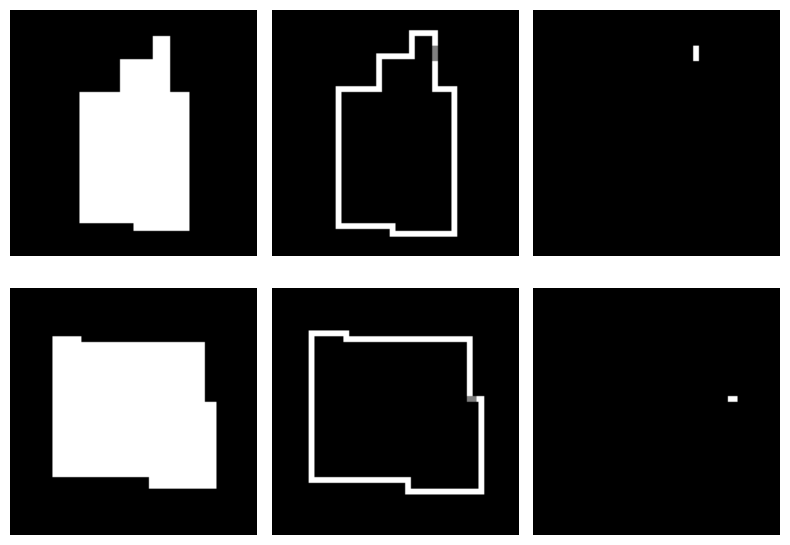

In [14]:
import matplotlib.pyplot as plt
img = t.cat((input[0], input[1]), dim=0)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(img[i].cpu(), cmap='gray')
    ax.axis("off")

plt.tight_layout()
plt.show()

## Vengono mostrati i punti target


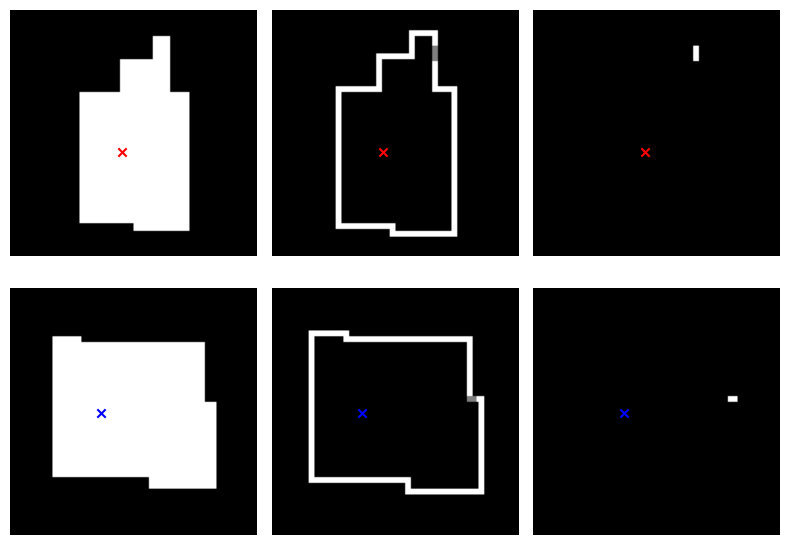

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(img[i].cpu(), cmap='gray')
    ax.axis('off')

    # Aggiungi le croci rosse alle posizioni specificate
    if i <=2:
      ax.scatter(target[0][0], target[0][1], color='red', marker='x')
    else:
      ax.scatter(target[1][0], target[1][1], color='blue', marker='x')

plt.tight_layout()

## Vengono comparati i punti target con i punti predetti dal modello


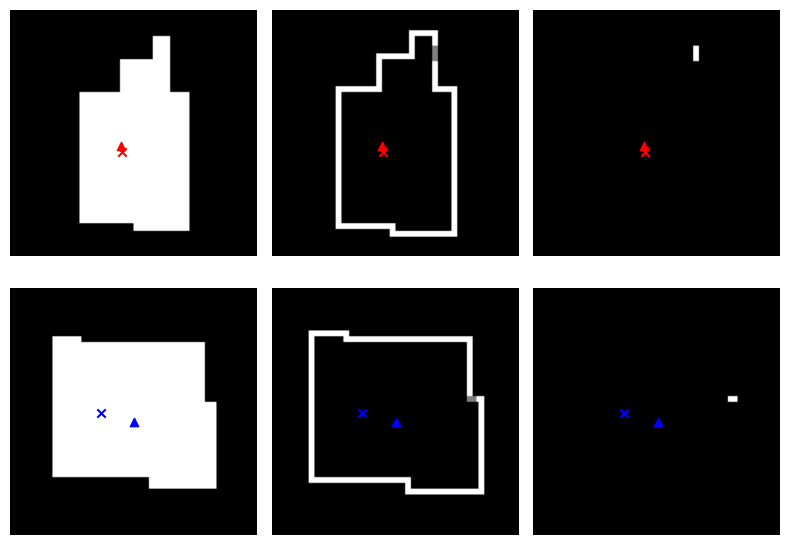

In [22]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(img[i].cpu(), cmap='gray')
    ax.axis('off')

    if i <=2:
      ax.scatter(target[0][0], target[0][1], color='red', marker='x')
      ax.scatter(output[0][0], output[0][1], color='red', marker='^')
    else:
      ax.scatter(target[1][0], target[1][1], color='blue', marker='x')
      ax.scatter(output[1][0], output[1][1], color='blue', marker='^')

plt.tight_layout()

## Vengono comparati i punti target con i punti predetti dal modello

Come si può vedere il modello da un valore troppo grande nell'asse delle x che porta la predizione fuori dal boundary del progetto.

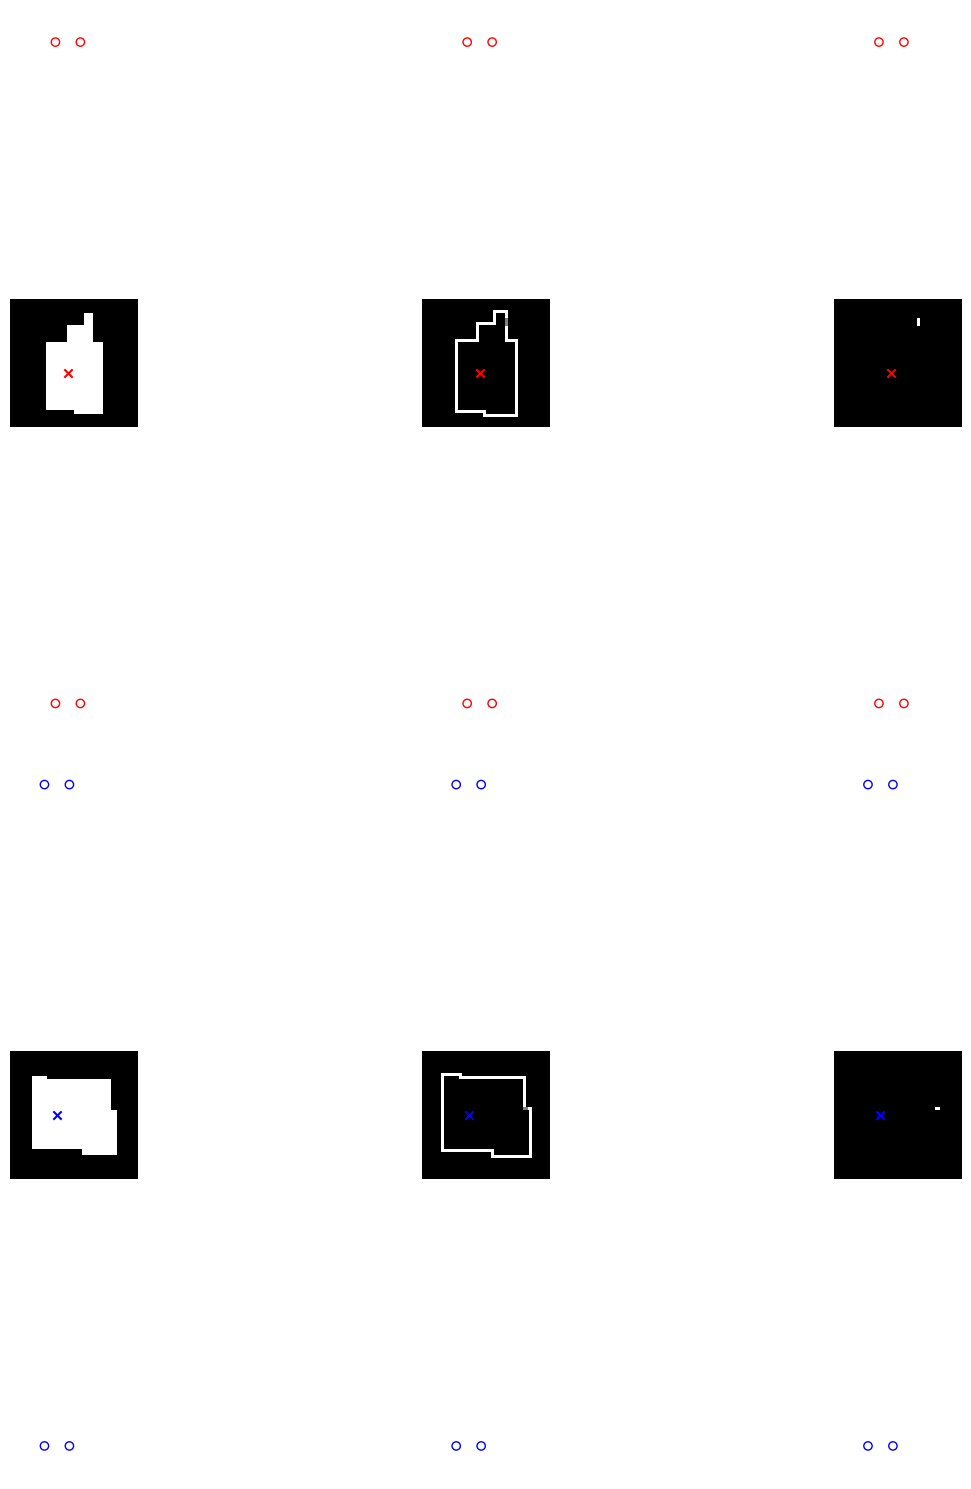

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 15))


for i, ax in enumerate(axes.flat):
    ax.imshow(img[i].cpu(), cmap='gray')
    ax.axis('off')

    if i <=2:

      ax.scatter(target[0][0], target[0][1], color='red', marker='x')
      ax.scatter(target[0][0] + distance_error[0], target[0][1] +distance_error[1], color='red', marker='o', facecolors='none')
      ax.scatter(target[0][0] - distance_error[0], target[0][1] +distance_error[1], color='red', marker='o', facecolors='none')
      ax.scatter(target[0][0] + distance_error[0], target[0][1] -distance_error[1], color='red', marker='o', facecolors='none')
      ax.scatter(target[0][0] - distance_error[0], target[0][1] -distance_error[1], color='red', marker='o', facecolors='none')
    else:
      ax.scatter(target[1][0], target[1][1], color='blue', marker='x')
      ax.scatter(target[1][0] + distance_error[0], target[1][1] +distance_error[1], color='blue', marker='o', facecolors='none')
      ax.scatter(target[1][0] - distance_error[0], target[1][1] +distance_error[1], color='blue', marker='o', facecolors='none')
      ax.scatter(target[1][0] + distance_error[0], target[1][1] -distance_error[1], color='blue', marker='o', facecolors='none')
      ax.scatter(target[1][0] - distance_error[0], target[1][1] -distance_error[1], color='blue', marker='o', facecolors='none')


plt.tight_layout()
plt.show()
